## Data description

The data comprises 5,574 SMS messages. Each message is labelled as either 'ham' (legitimate) or spam.

Each line in `data.txt` corresponds to one message. The first word is the data label (either `ham` or `spam`), followed by a tab (`\t`) character and then the message.

In [1]:
with open('data/data.txt', 'r') as f:
    msgs = f.read().splitlines()

In [2]:
print(msgs[10])
print(msgs[11])

ham	I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enough today.
spam	SIX chances to win CASH! From 100 to 20,000 pounds txt> CSH11 and send to 87575. Cost 150p/day, 6days, 16+ TsandCs apply Reply HL 4 info


In [1]:
# import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import collections
from sklearn import preprocessing, naive_bayes
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.svm import SVC
from flair.data_fetcher import NLPTaskDataFetcher
from flair.embeddings import WordEmbeddings, DocumentLSTMEmbeddings, BertEmbeddings, FlairEmbeddings
from flair.models import TextClassifier
from flair.trainers import ModelTrainer
from pathlib import Path
import tqdm
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

# Exploratory Data Analysis

### Summarise the data and highlight any interesting characteristics

In [2]:
def convert_txt_to_df(txt_file):
    """Produces a dataframe with label & message as columns from an input txt file where label & message share 1 line
    :param txt_file: raw text file where each line consists of a label, tab separator and a message
    :return: Pandas DataFrame containing columns 'label', and 'message'
    """
    with open(txt_file, 'r') as f:
        msgs = f.read().splitlines()
    df = pd.DataFrame(msgs)
    df[['label','message']] = df[0].str.split('\t',expand=True)
    df.drop([0], axis=1, inplace=True)
    return df

In [3]:
def plot_message_length_per_label(df, no_of_labels, name_of_label_column, name_of_content_column):
    """Get the n most used categories and plot a box plot of the lengths of texts within each"""
    df['text_length'] = df[name_of_content_column].str.len()
    top_five_categorical_target = df.loc[df[name_of_label_column].isin(df[name_of_label_column].value_counts().nlargest(no_of_labels).index)]
    plt.figure(figsize=(12.8,6))
    sns.boxplot(data=top_five_categorical_target, x=name_of_label_column, y='text_length', width=.5)
    plt.title("Length of Messages per Label", fontsize=16)
    plt.show()

In [4]:
def view_total_number_nulls_per_column(dataframe_to_check):
    """View the total number of null rows per column in a given dataframe"""
    null_columns=dataframe_to_check.columns[dataframe_to_check.isnull().any()]
    return dataframe_to_check[null_columns].isnull().sum()

In [5]:
def plot_label_proportions(df, column_with_labels):
    """For every label in df, calculate the proportion of rows that belong to them"""
    proportion_dict = {}
    lst_of_labels = df[column_with_labels].unique()
    
    for i in range(len(df[column_with_labels].unique())):
        proportion_dict[lst_of_labels[i]] = (len(df[df[column_with_labels]==lst_of_labels[i]])/len(df))*100

    pd.DataFrame([proportion_dict]).plot.bar()
    plt.title("Proportion of the Dataset per Label", fontsize=16)
    plt.ylabel('Percentage')
    plt.xticks([])
    plt.show()

In [6]:
# What does the data look like?
df = convert_txt_to_df('data/data.txt')
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


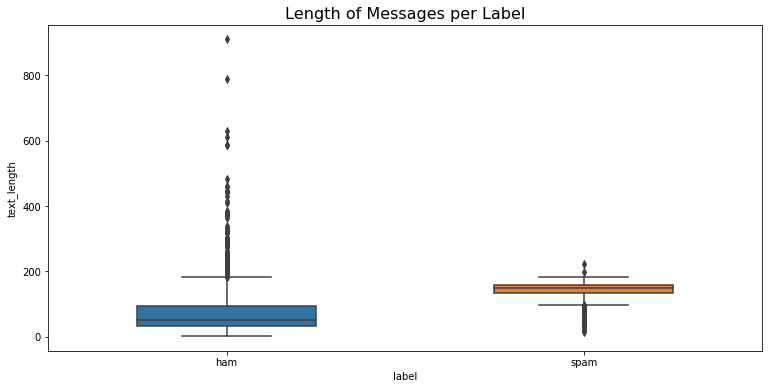

In [7]:
plot_message_length_per_label(df, 2, 'label', 'message')

In [8]:
view_total_number_nulls_per_column(df)

Series([], dtype: float64)

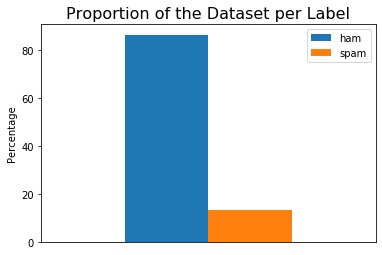

In [9]:
plot_label_proportions(df, 'label')

Summary of the Data

- The first very important observation is that we have imbalanced classes, more data is assigned to the label "ham"
- Another interested observation, as highlighted by the boxplot chart is that "spam" message length tends to be consistently shorter, whilst "ham" messages are also mostly short, but we see more variation in the length as indicated by the longer tail

### Pre-process Data/Clean the Text

In [10]:
def clean_the_text(df, text_column_to_clean):
    """Remove undesired characters from a dataframe with a specified column of text"""
    print('Cleaning the text...')
    
    new_column_name = text_column_to_clean + '_cleaned'
    df[new_column_name] = df[text_column_to_clean]

#     Remove quotation marks from text
    lst_of_speechmarks = ['"','”','“',"'"]
    for speechmark in lst_of_speechmarks:
        df[new_column_name] = df[new_column_name].str.replace(speechmark, '')
    
#     Make all text lowercase, so we don't have any repeats of words
    df[new_column_name] = df[new_column_name].str.lower()

#     Remove punctuation from text
    lst_of_punctuation_signs = list("?:!.,;()")
    for sign in lst_of_punctuation_signs:
        df[new_column_name] = df[new_column_name].str.replace(sign, '')
    
    return df

In [11]:
def remove_stop_words(df, column_to_remove_stop_words):
    """Remove stop words from dataframe with a specified column of text
    because they have no additive value and increase processing time"""
    print('Removing stop words...')
    
    nltk.download('stopwords')
    stop_words = list(stopwords.words('english'))

    for word in stop_words:
        regex_stopword = r"\b" + word + r"\b"
        df[column_to_remove_stop_words] = df[column_to_remove_stop_words].str.replace(regex_stopword, '')
        
    return df

In [12]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [13]:
def lemmatize_text_column(df, column_to_lemmatize):
    """For a given column of text in a dataframe, convert each word to a lemmatized version"""
    print('Lemmatizing the text...')
    
    lemmatizer = WordNetLemmatizer()

    nrows = len(df)
    lemmatized_text_list = []

    for row in range(0, nrows):
        print('Currently lemmatizing row number {} of {}'. format(row, nrows)) # Keep track of where we are
        # Save the text
        text = df.loc[row][column_to_lemmatize]
    
        # Lemmatize the sentences in the df with the appropriate POS tag
        lemmatized_text = [lemmatizer.lemmatize(w, pos = get_wordnet_pos(w)) for w in nltk.word_tokenize(text)]
    
        # Re-join the list
        lemmatized_text = " ".join(lemmatized_text)
    
        # Append to the list containing the texts
        lemmatized_text_list.append(lemmatized_text)
    
    new_column_name = column_to_lemmatize + '_lemmatized'
    df[new_column_name] = lemmatized_text_list

    return df

In [14]:
df = clean_the_text(df, 'message')
df = remove_stop_words(df, 'message_cleaned')
df = lemmatize_text_column(df, 'message_cleaned')

Cleaning the text...
Removing stop words...


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/oyinoguntoye/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Lemmatizing the text...
Currently lemmatizing row number 0 of 5574
Currently lemmatizing row number 1 of 5574
Currently lemmatizing row number 2 of 5574
Currently lemmatizing row number 3 of 5574
Currently lemmatizing row number 4 of 5574
Currently lemmatizing row number 5 of 5574
Currently lemmatizing row number 6 of 5574
Currently lemmatizing row number 7 of 5574
Currently lemmatizing row number 8 of 5574
Currently lemmatizing row number 9 of 5574
Currently lemmatizing row number 10 of 5574
Currently lemmatizing row number 11 of 5574
Currently lemmatizing row number 12 of 5574
Currently lemmatizing row number 13 of 5574
Currently lemmatizing row number 14 of 5574
Currently lemmatizing row number 15 of 5574
Currently lemmatizing row number 16 of 5574
Currently lemmatizing row number 17 of 5574
Currently lemmatizing row number 18 of 5574
Currently lemmatizing row number 19 of 5574
Currently lemmatizing row number 20 of 5574
Currently lemmatizing row number 21 of 5574
Currently lemmatiz

Currently lemmatizing row number 199 of 5574
Currently lemmatizing row number 200 of 5574
Currently lemmatizing row number 201 of 5574
Currently lemmatizing row number 202 of 5574
Currently lemmatizing row number 203 of 5574
Currently lemmatizing row number 204 of 5574
Currently lemmatizing row number 205 of 5574
Currently lemmatizing row number 206 of 5574
Currently lemmatizing row number 207 of 5574
Currently lemmatizing row number 208 of 5574
Currently lemmatizing row number 209 of 5574
Currently lemmatizing row number 210 of 5574
Currently lemmatizing row number 211 of 5574
Currently lemmatizing row number 212 of 5574
Currently lemmatizing row number 213 of 5574
Currently lemmatizing row number 214 of 5574
Currently lemmatizing row number 215 of 5574
Currently lemmatizing row number 216 of 5574
Currently lemmatizing row number 217 of 5574
Currently lemmatizing row number 218 of 5574
Currently lemmatizing row number 219 of 5574
Currently lemmatizing row number 220 of 5574
Currently 

Currently lemmatizing row number 382 of 5574
Currently lemmatizing row number 383 of 5574
Currently lemmatizing row number 384 of 5574
Currently lemmatizing row number 385 of 5574
Currently lemmatizing row number 386 of 5574
Currently lemmatizing row number 387 of 5574
Currently lemmatizing row number 388 of 5574
Currently lemmatizing row number 389 of 5574
Currently lemmatizing row number 390 of 5574
Currently lemmatizing row number 391 of 5574
Currently lemmatizing row number 392 of 5574
Currently lemmatizing row number 393 of 5574
Currently lemmatizing row number 394 of 5574
Currently lemmatizing row number 395 of 5574
Currently lemmatizing row number 396 of 5574
Currently lemmatizing row number 397 of 5574
Currently lemmatizing row number 398 of 5574
Currently lemmatizing row number 399 of 5574
Currently lemmatizing row number 400 of 5574
Currently lemmatizing row number 401 of 5574
Currently lemmatizing row number 402 of 5574
Currently lemmatizing row number 403 of 5574
Currently 

Currently lemmatizing row number 586 of 5574
Currently lemmatizing row number 587 of 5574
Currently lemmatizing row number 588 of 5574
Currently lemmatizing row number 589 of 5574
Currently lemmatizing row number 590 of 5574
Currently lemmatizing row number 591 of 5574
Currently lemmatizing row number 592 of 5574
Currently lemmatizing row number 593 of 5574
Currently lemmatizing row number 594 of 5574
Currently lemmatizing row number 595 of 5574
Currently lemmatizing row number 596 of 5574
Currently lemmatizing row number 597 of 5574
Currently lemmatizing row number 598 of 5574
Currently lemmatizing row number 599 of 5574
Currently lemmatizing row number 600 of 5574
Currently lemmatizing row number 601 of 5574
Currently lemmatizing row number 602 of 5574
Currently lemmatizing row number 603 of 5574
Currently lemmatizing row number 604 of 5574
Currently lemmatizing row number 605 of 5574
Currently lemmatizing row number 606 of 5574
Currently lemmatizing row number 607 of 5574
Currently 

Currently lemmatizing row number 782 of 5574
Currently lemmatizing row number 783 of 5574
Currently lemmatizing row number 784 of 5574
Currently lemmatizing row number 785 of 5574
Currently lemmatizing row number 786 of 5574
Currently lemmatizing row number 787 of 5574
Currently lemmatizing row number 788 of 5574
Currently lemmatizing row number 789 of 5574
Currently lemmatizing row number 790 of 5574
Currently lemmatizing row number 791 of 5574
Currently lemmatizing row number 792 of 5574
Currently lemmatizing row number 793 of 5574
Currently lemmatizing row number 794 of 5574
Currently lemmatizing row number 795 of 5574
Currently lemmatizing row number 796 of 5574
Currently lemmatizing row number 797 of 5574
Currently lemmatizing row number 798 of 5574
Currently lemmatizing row number 799 of 5574
Currently lemmatizing row number 800 of 5574
Currently lemmatizing row number 801 of 5574
Currently lemmatizing row number 802 of 5574
Currently lemmatizing row number 803 of 5574
Currently 

Currently lemmatizing row number 969 of 5574
Currently lemmatizing row number 970 of 5574
Currently lemmatizing row number 971 of 5574
Currently lemmatizing row number 972 of 5574
Currently lemmatizing row number 973 of 5574
Currently lemmatizing row number 974 of 5574
Currently lemmatizing row number 975 of 5574
Currently lemmatizing row number 976 of 5574
Currently lemmatizing row number 977 of 5574
Currently lemmatizing row number 978 of 5574
Currently lemmatizing row number 979 of 5574
Currently lemmatizing row number 980 of 5574
Currently lemmatizing row number 981 of 5574
Currently lemmatizing row number 982 of 5574
Currently lemmatizing row number 983 of 5574
Currently lemmatizing row number 984 of 5574
Currently lemmatizing row number 985 of 5574
Currently lemmatizing row number 986 of 5574
Currently lemmatizing row number 987 of 5574
Currently lemmatizing row number 988 of 5574
Currently lemmatizing row number 989 of 5574
Currently lemmatizing row number 990 of 5574
Currently 

Currently lemmatizing row number 1178 of 5574
Currently lemmatizing row number 1179 of 5574
Currently lemmatizing row number 1180 of 5574
Currently lemmatizing row number 1181 of 5574
Currently lemmatizing row number 1182 of 5574
Currently lemmatizing row number 1183 of 5574
Currently lemmatizing row number 1184 of 5574
Currently lemmatizing row number 1185 of 5574
Currently lemmatizing row number 1186 of 5574
Currently lemmatizing row number 1187 of 5574
Currently lemmatizing row number 1188 of 5574
Currently lemmatizing row number 1189 of 5574
Currently lemmatizing row number 1190 of 5574
Currently lemmatizing row number 1191 of 5574
Currently lemmatizing row number 1192 of 5574
Currently lemmatizing row number 1193 of 5574
Currently lemmatizing row number 1194 of 5574
Currently lemmatizing row number 1195 of 5574
Currently lemmatizing row number 1196 of 5574
Currently lemmatizing row number 1197 of 5574
Currently lemmatizing row number 1198 of 5574
Currently lemmatizing row number 1

Currently lemmatizing row number 1362 of 5574
Currently lemmatizing row number 1363 of 5574
Currently lemmatizing row number 1364 of 5574
Currently lemmatizing row number 1365 of 5574
Currently lemmatizing row number 1366 of 5574
Currently lemmatizing row number 1367 of 5574
Currently lemmatizing row number 1368 of 5574
Currently lemmatizing row number 1369 of 5574
Currently lemmatizing row number 1370 of 5574
Currently lemmatizing row number 1371 of 5574
Currently lemmatizing row number 1372 of 5574
Currently lemmatizing row number 1373 of 5574
Currently lemmatizing row number 1374 of 5574
Currently lemmatizing row number 1375 of 5574
Currently lemmatizing row number 1376 of 5574
Currently lemmatizing row number 1377 of 5574
Currently lemmatizing row number 1378 of 5574
Currently lemmatizing row number 1379 of 5574
Currently lemmatizing row number 1380 of 5574
Currently lemmatizing row number 1381 of 5574
Currently lemmatizing row number 1382 of 5574
Currently lemmatizing row number 1

Currently lemmatizing row number 1575 of 5574
Currently lemmatizing row number 1576 of 5574
Currently lemmatizing row number 1577 of 5574
Currently lemmatizing row number 1578 of 5574
Currently lemmatizing row number 1579 of 5574
Currently lemmatizing row number 1580 of 5574
Currently lemmatizing row number 1581 of 5574
Currently lemmatizing row number 1582 of 5574
Currently lemmatizing row number 1583 of 5574
Currently lemmatizing row number 1584 of 5574
Currently lemmatizing row number 1585 of 5574
Currently lemmatizing row number 1586 of 5574
Currently lemmatizing row number 1587 of 5574
Currently lemmatizing row number 1588 of 5574
Currently lemmatizing row number 1589 of 5574
Currently lemmatizing row number 1590 of 5574
Currently lemmatizing row number 1591 of 5574
Currently lemmatizing row number 1592 of 5574
Currently lemmatizing row number 1593 of 5574
Currently lemmatizing row number 1594 of 5574
Currently lemmatizing row number 1595 of 5574
Currently lemmatizing row number 1

Currently lemmatizing row number 1794 of 5574
Currently lemmatizing row number 1795 of 5574
Currently lemmatizing row number 1796 of 5574
Currently lemmatizing row number 1797 of 5574
Currently lemmatizing row number 1798 of 5574
Currently lemmatizing row number 1799 of 5574
Currently lemmatizing row number 1800 of 5574
Currently lemmatizing row number 1801 of 5574
Currently lemmatizing row number 1802 of 5574
Currently lemmatizing row number 1803 of 5574
Currently lemmatizing row number 1804 of 5574
Currently lemmatizing row number 1805 of 5574
Currently lemmatizing row number 1806 of 5574
Currently lemmatizing row number 1807 of 5574
Currently lemmatizing row number 1808 of 5574
Currently lemmatizing row number 1809 of 5574
Currently lemmatizing row number 1810 of 5574
Currently lemmatizing row number 1811 of 5574
Currently lemmatizing row number 1812 of 5574
Currently lemmatizing row number 1813 of 5574
Currently lemmatizing row number 1814 of 5574
Currently lemmatizing row number 1

Currently lemmatizing row number 1982 of 5574
Currently lemmatizing row number 1983 of 5574
Currently lemmatizing row number 1984 of 5574
Currently lemmatizing row number 1985 of 5574
Currently lemmatizing row number 1986 of 5574
Currently lemmatizing row number 1987 of 5574
Currently lemmatizing row number 1988 of 5574
Currently lemmatizing row number 1989 of 5574
Currently lemmatizing row number 1990 of 5574
Currently lemmatizing row number 1991 of 5574
Currently lemmatizing row number 1992 of 5574
Currently lemmatizing row number 1993 of 5574
Currently lemmatizing row number 1994 of 5574
Currently lemmatizing row number 1995 of 5574
Currently lemmatizing row number 1996 of 5574
Currently lemmatizing row number 1997 of 5574
Currently lemmatizing row number 1998 of 5574
Currently lemmatizing row number 1999 of 5574
Currently lemmatizing row number 2000 of 5574
Currently lemmatizing row number 2001 of 5574
Currently lemmatizing row number 2002 of 5574
Currently lemmatizing row number 2

Currently lemmatizing row number 2188 of 5574
Currently lemmatizing row number 2189 of 5574
Currently lemmatizing row number 2190 of 5574
Currently lemmatizing row number 2191 of 5574
Currently lemmatizing row number 2192 of 5574
Currently lemmatizing row number 2193 of 5574
Currently lemmatizing row number 2194 of 5574
Currently lemmatizing row number 2195 of 5574
Currently lemmatizing row number 2196 of 5574
Currently lemmatizing row number 2197 of 5574
Currently lemmatizing row number 2198 of 5574
Currently lemmatizing row number 2199 of 5574
Currently lemmatizing row number 2200 of 5574
Currently lemmatizing row number 2201 of 5574
Currently lemmatizing row number 2202 of 5574
Currently lemmatizing row number 2203 of 5574
Currently lemmatizing row number 2204 of 5574
Currently lemmatizing row number 2205 of 5574
Currently lemmatizing row number 2206 of 5574
Currently lemmatizing row number 2207 of 5574
Currently lemmatizing row number 2208 of 5574
Currently lemmatizing row number 2

Currently lemmatizing row number 2395 of 5574
Currently lemmatizing row number 2396 of 5574
Currently lemmatizing row number 2397 of 5574
Currently lemmatizing row number 2398 of 5574
Currently lemmatizing row number 2399 of 5574
Currently lemmatizing row number 2400 of 5574
Currently lemmatizing row number 2401 of 5574
Currently lemmatizing row number 2402 of 5574
Currently lemmatizing row number 2403 of 5574
Currently lemmatizing row number 2404 of 5574
Currently lemmatizing row number 2405 of 5574
Currently lemmatizing row number 2406 of 5574
Currently lemmatizing row number 2407 of 5574
Currently lemmatizing row number 2408 of 5574
Currently lemmatizing row number 2409 of 5574
Currently lemmatizing row number 2410 of 5574
Currently lemmatizing row number 2411 of 5574
Currently lemmatizing row number 2412 of 5574
Currently lemmatizing row number 2413 of 5574
Currently lemmatizing row number 2414 of 5574
Currently lemmatizing row number 2415 of 5574
Currently lemmatizing row number 2

Currently lemmatizing row number 2611 of 5574
Currently lemmatizing row number 2612 of 5574
Currently lemmatizing row number 2613 of 5574
Currently lemmatizing row number 2614 of 5574
Currently lemmatizing row number 2615 of 5574
Currently lemmatizing row number 2616 of 5574
Currently lemmatizing row number 2617 of 5574
Currently lemmatizing row number 2618 of 5574
Currently lemmatizing row number 2619 of 5574
Currently lemmatizing row number 2620 of 5574
Currently lemmatizing row number 2621 of 5574
Currently lemmatizing row number 2622 of 5574
Currently lemmatizing row number 2623 of 5574
Currently lemmatizing row number 2624 of 5574
Currently lemmatizing row number 2625 of 5574
Currently lemmatizing row number 2626 of 5574
Currently lemmatizing row number 2627 of 5574
Currently lemmatizing row number 2628 of 5574
Currently lemmatizing row number 2629 of 5574
Currently lemmatizing row number 2630 of 5574
Currently lemmatizing row number 2631 of 5574
Currently lemmatizing row number 2

Currently lemmatizing row number 2794 of 5574
Currently lemmatizing row number 2795 of 5574
Currently lemmatizing row number 2796 of 5574
Currently lemmatizing row number 2797 of 5574
Currently lemmatizing row number 2798 of 5574
Currently lemmatizing row number 2799 of 5574
Currently lemmatizing row number 2800 of 5574
Currently lemmatizing row number 2801 of 5574
Currently lemmatizing row number 2802 of 5574
Currently lemmatizing row number 2803 of 5574
Currently lemmatizing row number 2804 of 5574
Currently lemmatizing row number 2805 of 5574
Currently lemmatizing row number 2806 of 5574
Currently lemmatizing row number 2807 of 5574
Currently lemmatizing row number 2808 of 5574
Currently lemmatizing row number 2809 of 5574
Currently lemmatizing row number 2810 of 5574
Currently lemmatizing row number 2811 of 5574
Currently lemmatizing row number 2812 of 5574
Currently lemmatizing row number 2813 of 5574
Currently lemmatizing row number 2814 of 5574
Currently lemmatizing row number 2

Currently lemmatizing row number 2999 of 5574
Currently lemmatizing row number 3000 of 5574
Currently lemmatizing row number 3001 of 5574
Currently lemmatizing row number 3002 of 5574
Currently lemmatizing row number 3003 of 5574
Currently lemmatizing row number 3004 of 5574
Currently lemmatizing row number 3005 of 5574
Currently lemmatizing row number 3006 of 5574
Currently lemmatizing row number 3007 of 5574
Currently lemmatizing row number 3008 of 5574
Currently lemmatizing row number 3009 of 5574
Currently lemmatizing row number 3010 of 5574
Currently lemmatizing row number 3011 of 5574
Currently lemmatizing row number 3012 of 5574
Currently lemmatizing row number 3013 of 5574
Currently lemmatizing row number 3014 of 5574
Currently lemmatizing row number 3015 of 5574
Currently lemmatizing row number 3016 of 5574
Currently lemmatizing row number 3017 of 5574
Currently lemmatizing row number 3018 of 5574
Currently lemmatizing row number 3019 of 5574
Currently lemmatizing row number 3

Currently lemmatizing row number 3188 of 5574
Currently lemmatizing row number 3189 of 5574
Currently lemmatizing row number 3190 of 5574
Currently lemmatizing row number 3191 of 5574
Currently lemmatizing row number 3192 of 5574
Currently lemmatizing row number 3193 of 5574
Currently lemmatizing row number 3194 of 5574
Currently lemmatizing row number 3195 of 5574
Currently lemmatizing row number 3196 of 5574
Currently lemmatizing row number 3197 of 5574
Currently lemmatizing row number 3198 of 5574
Currently lemmatizing row number 3199 of 5574
Currently lemmatizing row number 3200 of 5574
Currently lemmatizing row number 3201 of 5574
Currently lemmatizing row number 3202 of 5574
Currently lemmatizing row number 3203 of 5574
Currently lemmatizing row number 3204 of 5574
Currently lemmatizing row number 3205 of 5574
Currently lemmatizing row number 3206 of 5574
Currently lemmatizing row number 3207 of 5574
Currently lemmatizing row number 3208 of 5574
Currently lemmatizing row number 3

Currently lemmatizing row number 3408 of 5574
Currently lemmatizing row number 3409 of 5574
Currently lemmatizing row number 3410 of 5574
Currently lemmatizing row number 3411 of 5574
Currently lemmatizing row number 3412 of 5574
Currently lemmatizing row number 3413 of 5574
Currently lemmatizing row number 3414 of 5574
Currently lemmatizing row number 3415 of 5574
Currently lemmatizing row number 3416 of 5574
Currently lemmatizing row number 3417 of 5574
Currently lemmatizing row number 3418 of 5574
Currently lemmatizing row number 3419 of 5574
Currently lemmatizing row number 3420 of 5574
Currently lemmatizing row number 3421 of 5574
Currently lemmatizing row number 3422 of 5574
Currently lemmatizing row number 3423 of 5574
Currently lemmatizing row number 3424 of 5574
Currently lemmatizing row number 3425 of 5574
Currently lemmatizing row number 3426 of 5574
Currently lemmatizing row number 3427 of 5574
Currently lemmatizing row number 3428 of 5574
Currently lemmatizing row number 3

Currently lemmatizing row number 3614 of 5574
Currently lemmatizing row number 3615 of 5574
Currently lemmatizing row number 3616 of 5574
Currently lemmatizing row number 3617 of 5574
Currently lemmatizing row number 3618 of 5574
Currently lemmatizing row number 3619 of 5574
Currently lemmatizing row number 3620 of 5574
Currently lemmatizing row number 3621 of 5574
Currently lemmatizing row number 3622 of 5574
Currently lemmatizing row number 3623 of 5574
Currently lemmatizing row number 3624 of 5574
Currently lemmatizing row number 3625 of 5574
Currently lemmatizing row number 3626 of 5574
Currently lemmatizing row number 3627 of 5574
Currently lemmatizing row number 3628 of 5574
Currently lemmatizing row number 3629 of 5574
Currently lemmatizing row number 3630 of 5574
Currently lemmatizing row number 3631 of 5574
Currently lemmatizing row number 3632 of 5574
Currently lemmatizing row number 3633 of 5574
Currently lemmatizing row number 3634 of 5574
Currently lemmatizing row number 3

Currently lemmatizing row number 3805 of 5574
Currently lemmatizing row number 3806 of 5574
Currently lemmatizing row number 3807 of 5574
Currently lemmatizing row number 3808 of 5574
Currently lemmatizing row number 3809 of 5574
Currently lemmatizing row number 3810 of 5574
Currently lemmatizing row number 3811 of 5574
Currently lemmatizing row number 3812 of 5574
Currently lemmatizing row number 3813 of 5574
Currently lemmatizing row number 3814 of 5574
Currently lemmatizing row number 3815 of 5574
Currently lemmatizing row number 3816 of 5574
Currently lemmatizing row number 3817 of 5574
Currently lemmatizing row number 3818 of 5574
Currently lemmatizing row number 3819 of 5574
Currently lemmatizing row number 3820 of 5574
Currently lemmatizing row number 3821 of 5574
Currently lemmatizing row number 3822 of 5574
Currently lemmatizing row number 3823 of 5574
Currently lemmatizing row number 3824 of 5574
Currently lemmatizing row number 3825 of 5574
Currently lemmatizing row number 3

Currently lemmatizing row number 4006 of 5574
Currently lemmatizing row number 4007 of 5574
Currently lemmatizing row number 4008 of 5574
Currently lemmatizing row number 4009 of 5574
Currently lemmatizing row number 4010 of 5574
Currently lemmatizing row number 4011 of 5574
Currently lemmatizing row number 4012 of 5574
Currently lemmatizing row number 4013 of 5574
Currently lemmatizing row number 4014 of 5574
Currently lemmatizing row number 4015 of 5574
Currently lemmatizing row number 4016 of 5574
Currently lemmatizing row number 4017 of 5574
Currently lemmatizing row number 4018 of 5574
Currently lemmatizing row number 4019 of 5574
Currently lemmatizing row number 4020 of 5574
Currently lemmatizing row number 4021 of 5574
Currently lemmatizing row number 4022 of 5574
Currently lemmatizing row number 4023 of 5574
Currently lemmatizing row number 4024 of 5574
Currently lemmatizing row number 4025 of 5574
Currently lemmatizing row number 4026 of 5574
Currently lemmatizing row number 4

Currently lemmatizing row number 4222 of 5574
Currently lemmatizing row number 4223 of 5574
Currently lemmatizing row number 4224 of 5574
Currently lemmatizing row number 4225 of 5574
Currently lemmatizing row number 4226 of 5574
Currently lemmatizing row number 4227 of 5574
Currently lemmatizing row number 4228 of 5574
Currently lemmatizing row number 4229 of 5574
Currently lemmatizing row number 4230 of 5574
Currently lemmatizing row number 4231 of 5574
Currently lemmatizing row number 4232 of 5574
Currently lemmatizing row number 4233 of 5574
Currently lemmatizing row number 4234 of 5574
Currently lemmatizing row number 4235 of 5574
Currently lemmatizing row number 4236 of 5574
Currently lemmatizing row number 4237 of 5574
Currently lemmatizing row number 4238 of 5574
Currently lemmatizing row number 4239 of 5574
Currently lemmatizing row number 4240 of 5574
Currently lemmatizing row number 4241 of 5574
Currently lemmatizing row number 4242 of 5574
Currently lemmatizing row number 4

Currently lemmatizing row number 4409 of 5574
Currently lemmatizing row number 4410 of 5574
Currently lemmatizing row number 4411 of 5574
Currently lemmatizing row number 4412 of 5574
Currently lemmatizing row number 4413 of 5574
Currently lemmatizing row number 4414 of 5574
Currently lemmatizing row number 4415 of 5574
Currently lemmatizing row number 4416 of 5574
Currently lemmatizing row number 4417 of 5574
Currently lemmatizing row number 4418 of 5574
Currently lemmatizing row number 4419 of 5574
Currently lemmatizing row number 4420 of 5574
Currently lemmatizing row number 4421 of 5574
Currently lemmatizing row number 4422 of 5574
Currently lemmatizing row number 4423 of 5574
Currently lemmatizing row number 4424 of 5574
Currently lemmatizing row number 4425 of 5574
Currently lemmatizing row number 4426 of 5574
Currently lemmatizing row number 4427 of 5574
Currently lemmatizing row number 4428 of 5574
Currently lemmatizing row number 4429 of 5574
Currently lemmatizing row number 4

Currently lemmatizing row number 4629 of 5574
Currently lemmatizing row number 4630 of 5574
Currently lemmatizing row number 4631 of 5574
Currently lemmatizing row number 4632 of 5574
Currently lemmatizing row number 4633 of 5574
Currently lemmatizing row number 4634 of 5574
Currently lemmatizing row number 4635 of 5574
Currently lemmatizing row number 4636 of 5574
Currently lemmatizing row number 4637 of 5574
Currently lemmatizing row number 4638 of 5574
Currently lemmatizing row number 4639 of 5574
Currently lemmatizing row number 4640 of 5574
Currently lemmatizing row number 4641 of 5574
Currently lemmatizing row number 4642 of 5574
Currently lemmatizing row number 4643 of 5574
Currently lemmatizing row number 4644 of 5574
Currently lemmatizing row number 4645 of 5574
Currently lemmatizing row number 4646 of 5574
Currently lemmatizing row number 4647 of 5574
Currently lemmatizing row number 4648 of 5574
Currently lemmatizing row number 4649 of 5574
Currently lemmatizing row number 4

Currently lemmatizing row number 4819 of 5574
Currently lemmatizing row number 4820 of 5574
Currently lemmatizing row number 4821 of 5574
Currently lemmatizing row number 4822 of 5574
Currently lemmatizing row number 4823 of 5574
Currently lemmatizing row number 4824 of 5574
Currently lemmatizing row number 4825 of 5574
Currently lemmatizing row number 4826 of 5574
Currently lemmatizing row number 4827 of 5574
Currently lemmatizing row number 4828 of 5574
Currently lemmatizing row number 4829 of 5574
Currently lemmatizing row number 4830 of 5574
Currently lemmatizing row number 4831 of 5574
Currently lemmatizing row number 4832 of 5574
Currently lemmatizing row number 4833 of 5574
Currently lemmatizing row number 4834 of 5574
Currently lemmatizing row number 4835 of 5574
Currently lemmatizing row number 4836 of 5574
Currently lemmatizing row number 4837 of 5574
Currently lemmatizing row number 4838 of 5574
Currently lemmatizing row number 4839 of 5574
Currently lemmatizing row number 4

Currently lemmatizing row number 5018 of 5574
Currently lemmatizing row number 5019 of 5574
Currently lemmatizing row number 5020 of 5574
Currently lemmatizing row number 5021 of 5574
Currently lemmatizing row number 5022 of 5574
Currently lemmatizing row number 5023 of 5574
Currently lemmatizing row number 5024 of 5574
Currently lemmatizing row number 5025 of 5574
Currently lemmatizing row number 5026 of 5574
Currently lemmatizing row number 5027 of 5574
Currently lemmatizing row number 5028 of 5574
Currently lemmatizing row number 5029 of 5574
Currently lemmatizing row number 5030 of 5574
Currently lemmatizing row number 5031 of 5574
Currently lemmatizing row number 5032 of 5574
Currently lemmatizing row number 5033 of 5574
Currently lemmatizing row number 5034 of 5574
Currently lemmatizing row number 5035 of 5574
Currently lemmatizing row number 5036 of 5574
Currently lemmatizing row number 5037 of 5574
Currently lemmatizing row number 5038 of 5574
Currently lemmatizing row number 5

Currently lemmatizing row number 5230 of 5574
Currently lemmatizing row number 5231 of 5574
Currently lemmatizing row number 5232 of 5574
Currently lemmatizing row number 5233 of 5574
Currently lemmatizing row number 5234 of 5574
Currently lemmatizing row number 5235 of 5574
Currently lemmatizing row number 5236 of 5574
Currently lemmatizing row number 5237 of 5574
Currently lemmatizing row number 5238 of 5574
Currently lemmatizing row number 5239 of 5574
Currently lemmatizing row number 5240 of 5574
Currently lemmatizing row number 5241 of 5574
Currently lemmatizing row number 5242 of 5574
Currently lemmatizing row number 5243 of 5574
Currently lemmatizing row number 5244 of 5574
Currently lemmatizing row number 5245 of 5574
Currently lemmatizing row number 5246 of 5574
Currently lemmatizing row number 5247 of 5574
Currently lemmatizing row number 5248 of 5574
Currently lemmatizing row number 5249 of 5574
Currently lemmatizing row number 5250 of 5574
Currently lemmatizing row number 5

Currently lemmatizing row number 5415 of 5574
Currently lemmatizing row number 5416 of 5574
Currently lemmatizing row number 5417 of 5574
Currently lemmatizing row number 5418 of 5574
Currently lemmatizing row number 5419 of 5574
Currently lemmatizing row number 5420 of 5574
Currently lemmatizing row number 5421 of 5574
Currently lemmatizing row number 5422 of 5574
Currently lemmatizing row number 5423 of 5574
Currently lemmatizing row number 5424 of 5574
Currently lemmatizing row number 5425 of 5574
Currently lemmatizing row number 5426 of 5574
Currently lemmatizing row number 5427 of 5574
Currently lemmatizing row number 5428 of 5574
Currently lemmatizing row number 5429 of 5574
Currently lemmatizing row number 5430 of 5574
Currently lemmatizing row number 5431 of 5574
Currently lemmatizing row number 5432 of 5574
Currently lemmatizing row number 5433 of 5574
Currently lemmatizing row number 5434 of 5574
Currently lemmatizing row number 5435 of 5574
Currently lemmatizing row number 5

In [15]:
def plot_most_used_words(df, label_to_count, column_to_count, no_most_common):
    """Get the n most used words in all the text for a given column in the dataset"""
    
    # Instantiate a dictionary, to count every word in the messages
    wordcount = {}

    df = df[df['label'] == label_to_count]

    for row in df[column_to_count]:
        for word in row.split():
            if word not in wordcount:
                wordcount[word] = 1
            else:
                wordcount[word] += 1

    word_counter = collections.Counter(wordcount)
    
    # Draw a bar chart
    lst = word_counter.most_common(no_most_common)
    pd.DataFrame(lst, columns = ['Word', 'Count']).plot.bar(x='Word',y='Count')
    plt.title("Top {} Most Used Words for the '{}' Label".format(no_most_common, label_to_count), fontsize=16)
    plt.show()

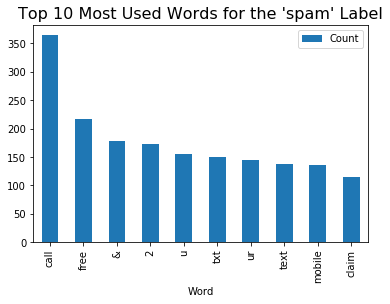

In [16]:
plot_most_used_words(df, 'spam', 'message_cleaned_lemmatized', 10)

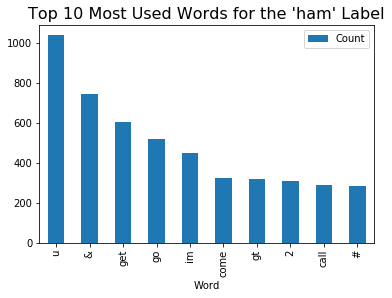

In [17]:
plot_most_used_words(df, 'ham', 'message_cleaned_lemmatized', 10)

In [18]:
def visualise_word_count(df, label_to_visualise):
    """Create word cloud plots for a given label in the dataset"""
    words = ''
    for msg in df[df['label'] == label_to_visualise]['message_cleaned_lemmatized']:
        words += msg + ' '
    wordcloud = WordCloud(width=1600, height=800).generate(words)
    plt.figure( figsize=(10,10) )
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title("Word Cloud for Messages Marked as '{}'".format(label_to_visualise), fontsize=16)
    plt.show()

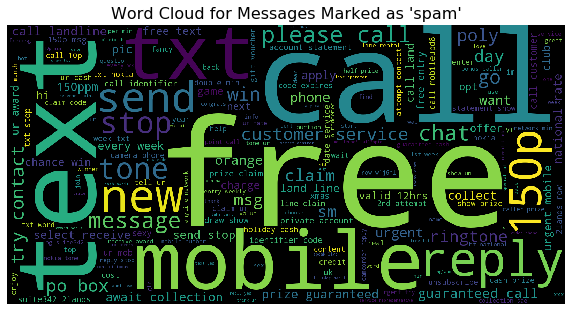

In [19]:
visualise_word_count(df, 'spam')

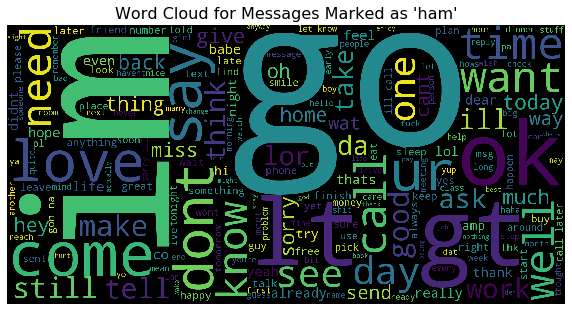

In [20]:
visualise_word_count(df, 'ham')

The word cloud chart and the Top 10 Most Used Words bar chart are both based on the frequency of the words, hence it's better to plot this after removing stop words, because stop words tend to be used very frequently and would take up a majority of the focus of the word cloud.

In general, very short words are used both in both spam & ham texts, but these charts display the fact that words like "free", "reply" and "call" are used most when spam messages are sent.

# Model Training

### Label Encoding

The variable we want to predict is categorical, so we will encode these labels so they're machine interpretable

In [21]:
def encode_categorical_variables(df, target_column):
    """Turn categorical target variable names into numerical values"""
    label_encoder = preprocessing.LabelEncoder() 
  
    # Encode labels in column 'species'
    new_column_name = target_column + '_encoded'
    df[new_column_name] = label_encoder.fit_transform(df[target_column])
    return df

In [22]:
df = encode_categorical_variables(df, 'label')

### Train-Test Split

Set aside a test set to prove the quality of the model. Use the train set for Cross Validation to tune the hyperparameters and then finally test performance on the unseen data of the test set.

In [23]:
def my_train_test_split(df, x_column, y_column):
    """Split the dataset into training (80%) and test (20%) sets"""
    X_train, X_test, y_train, y_test = train_test_split(df[x_column], df[y_column], test_size=0.2, random_state=18)
    return X_train, X_test, y_train, y_test

### TF-IDF Language Model

Using simple count vectorising to convert the text to machine readable format isn’t helpful with real data, because we can have words repeated many times that don't provide a lot of meaningful info. Instead we'll use TF-IDF Vectors as features.

TF-IDF weight is product of two terms: the first term is the normalized Term Frequency (TF), aka. the number of times a word appears in a document, divided by the total number of words in that document; the second term is the Inverse Document Frequency (IDF), computed as the log of the number of the documents in the corpus divided by the number of documents where the specific term appears.

TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document).

IDF(t) = log_e(Total number of documents / Number of documents with term t in it).

In [24]:
def embed_text_features(X_train, X_test):
    """Use TF-IDF to vectorise the text column in preparation for the model"""
    vectorizer = TfidfVectorizer()
    x_train_modified = vectorizer.fit_transform(X_train).todense()
    x_test_modified = vectorizer.transform(X_test).todense()
    return x_train_modified, x_test_modified

In [25]:
X_train, X_test, y_train, y_test = my_train_test_split(df, 'message_cleaned_lemmatized', 'label_encoded')
x_train_modified, x_test_modified = embed_text_features(X_train, X_test)

### Train the Models (Naive Bayes & Support Vector Machine)

We're using Naive Bayes here, a common text classification algorithm applied frequently to determine if they're spam or ham

It's important to note that we have heavily imbalanced class here, as ~80% of the messages are ham, not spam. 
To overcome this issue, we'll assess the Naive Bayes model with the metrics precision, recall and F1 score rather than using accuracy as these are better suited to imbalanced classes. These scores take into consideration the distribution of the classes present.
We'll also train the model using a penalized version of Support Vector Machine for comparison.

In [26]:
def fit_nb_model(x_train, y_train, x_test, y_test):
    """Fit Naives Bayes model to the training data, then validate it on unseen test data and show the performance"""

    # Fit the model
    Naive = naive_bayes.MultinomialNB()
    Naive.fit(x_train, y_train)
    
    # Predict the labels on validation dataset
    predictions_nb = Naive.predict(x_test)

    # Return results
    print("Naive Bayes Model Precision Score: ", precision_score(y_test, predictions_nb),
         "Recall Score: ", recall_score(y_test, predictions_nb, average='macro'),
         "F1 Score: ", f1_score(y_test, predictions_nb, average='macro'),
         "Classes the model is predicting: ", np.unique(predictions_nb))
    return Naive

In [27]:
Naive = fit_nb_model(x_train_modified, y_train, x_test_modified, y_test)

Naive Bayes Model Precision Score:  1.0 Recall Score:  0.8804347826086957 F1 Score:  0.9237947895891194 Classes the model is predicting:  [0 1]


In [28]:
def fit_penalised_svm_model(x_train, y_train, x_test, y_test):
    """Fit Penalized SVM model to the training data, then validate it on unseen test data and show the performance"""

    # Fit the model
    SVM = SVC(kernel='linear', class_weight='balanced', probability=True)
    SVM.fit(x_train, y_train)
    
    # Predict the labels on validation dataset
    predictions_svm = SVM.predict(x_test)

    # Return results
    print("SVM Model Precision Score: ", precision_score(y_test, predictions_svm),
         "Recall Score: ", recall_score(y_test, predictions_svm, average='macro'),
         "F1 Score: ", f1_score(y_test, predictions_svm, average='macro'),
         "Classes the model is predicting: ", np.unique(predictions_svm))
    
    return SVM

In [29]:
SVM = fit_penalised_svm_model(x_train_modified, y_train, x_test_modified, y_test)

SVM Model Precision Score:  0.9465648854961832 Recall Score:  0.9456929672318395 F1 Score:  0.955612131736141 Classes the model is predicting:  [0 1]


### Train Model using Deep Learning

We're using word embedding here. This is when words are represented by dense vectors (rather than sparse) with the projection of the word into a continuous vector space. The position of a word within the vector space is learned from text and is based on the words that surround the word when it is used.

Our word embedding is utilising a method called transfer learning here, someone else has trained a model on a huge corpus and we're making use of this pre-trained model. There are various pretrained word embeddings, such as Word2Vec, GloVe, ELMo and BERT.
We've chosen GloVe 100d, the 100-dimensional version of the embedding

Note, we're combining the word embedding with an LSTM layer, which improves the basic RNN algorithm by solving the vanishing problem by adding  states for remembering or forgetting data

Steps:
1. Clean and convert the text to integer format (using keras in-built method)
2. Use the pre-trained word embedding model to create weights for the neural network
3. Construct the model (input layer = embedded layer, hidden layer = RNN (LSTM))
4. Train the model
5. Evaluate the model

In [30]:
dl_df = convert_txt_to_df('data/data.txt')
dl_df['input_length'] = dl_df['message'].str.count(' ') + 1 # Get the number of words per text

x = dl_df['message']
y = dl_df['label']

In [31]:
# Initialise variables
SEQUENCE_LENGTH = dl_df['input_length'].max()
EMBEDDING_SIZE = 100
BATCH_SIZE = 64
EPOCHS = 10
EMBEDDING_DIM = 100

# fix random seed for reproducibility
np.random.seed(7)

# to convert labels to integers and vice-versa
label2int = {"ham": 0, "spam": 1}

In [32]:
def preprocess_dl_data(x, y):
    """Perform necessary text pre-processing functions to prepare the data for the model"""
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(x)
    x = tokenizer.texts_to_sequences(x)
    
    # convert to numpy arrays
    x = np.array(x)
    y = np.array(y)
    
    # Pad the vectors so they all are the same length, a requirement for the model
    x = pad_sequences(x, maxlen=SEQUENCE_LENGTH)
    
    # One-hot encode the labels
    y = [label2int[label] for label in y]
    y = to_categorical(y)
    
    # Split the data into training & test sets
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=18)
    return tokenizer, x_train, x_test, y_train, y_test

In [33]:
def get_embedding_vectors(tokenizer, dim=EMBEDDING_DIM):
    """Load the pre-trained GloVe word embedding model to be used for transfer learning"""
    # Construct a dictionary with the vocab/vectors from the GloVe pretrained word embedding model
    embedding_index = {}
    with open(f"glove.6B.100d.txt", encoding='utf8') as f:
        for line in tqdm.tqdm(f, "Loading GloVe Data"):
            values = line.split()
            word = values[0]
            vectors = np.asarray(values[1:], dtype='float32')
            embedding_index[word] = vectors

    # Construct a matrix where every word in my dataset is 
    # assigned to an index with its corresponding GloVe vector in that position in the matrix
    word_index = tokenizer.word_index
    embedding_matrix = np.zeros((len(word_index)+1, dim))
    for word, index in word_index.items():
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector
            
    return embedding_matrix

In [34]:
def get_model(tokenizer, lstm_units):
    """Constructs the model: Embedding vectors, LSTM, and 2 output Fully-Connected neurons with softmax activation function"""
    embedding_matrix = get_embedding_vectors(tokenizer)
    model = Sequential()
    
    # Set trainable = False, because we don't want to update the learned word weights in this model
    model.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=EMBEDDING_SIZE, 
                        weights=[embedding_matrix], trainable=False, input_length=SEQUENCE_LENGTH))
    model.add(LSTM(lstm_units, recurrent_dropout=0.2))
    model.add(Dropout(0.3)) # 30% dropout will freeze 30% of neurons in previous layer per iteration to help reduce overfitting
    model.add(Dense(2, activation="softmax")) # it's binary classification, so using sigmoid is same as softmax

    model.compile(optimizer="adam", loss="categorical_crossentropy") # multi-class problem, so using categorical_crossentropy
    model.summary()
    return model

In [35]:
def fit_dl_model(tokenizer, x_train, y_train, x_test, y_test, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1):
    """Fit Deep Learning model to the training data, then validate it on unseen test data and show the performance"""

    # Fit the model
    DL = get_model(tokenizer, lstm_units=128)
    # print our data shapes
    print("x_train.shape:", x_train.shape)
    print("x_test.shape:", x_test.shape)
    print("y_train.shape:", y_train.shape)
    print("y_test.shape:", y_test.shape)
    DL.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1)    
    
    # Predict the labels on validation dataset
    predictions_dl = DL.predict(x_test)
    predictions_dl = np.argmax(predictions_dl, axis=1)
    y_test = np.argmax(y_test, axis=1)

    # Return results
    print("\n\nDeep Learning Model Precision Score: ", precision_score(y_test, predictions_dl),
         "Recall Score: ", recall_score(y_test, predictions_dl, average='macro'),
         "F1 Score: ", f1_score(y_test, predictions_dl, average='macro'),
         "Classes the model is predicting: ", np.unique(predictions_dl))
    
    return DL

In [36]:
tokenizer, x_train, x_test, y_train, y_test = preprocess_dl_data(x, y)

In [37]:
DL = fit_dl_model(tokenizer, x_train, y_train, x_test, y_test)

Loading GloVe Data: 400000it [00:32, 12273.42it/s]


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 171, 100)          901000    
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 2)                 258       
Total params: 1,018,506
Trainable params: 117,506
Non-trainable params: 901,000
_________________________________________________________________
x_train.shape: (4459, 171)
x_test.shape: (1115, 171)
y_train.shape: (4459, 2)
y_test.shape: (1115, 2)
Train on 4459 samples, validate on 1115 samples
Epoch 1/10
4459/4459 [==============================] - 60s 13ms/sample - loss: 0.2045 - v

### Summary

We see that in general, all the models have good F1 scores, with no model having an F1 score less than 90%.

Based on the metrics, it appears that the deep learning model outperforms closely followed by the SVM.
